In [2]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV

from sklearn.tree import export_graphviz

In [3]:
df = pd.read_csv("../CSV/SantaMariaPOWER.csv", delimiter=',')

In [4]:
df.head()

,LAT,LON,YEAR,DOY,PRECTOT,WS2M,T2MDEW,RH2M,T2M_MAX,T2M_MIN,T2M,ALLSKY_TOA_SW_DWN,ALLSKY_SFC_SW_DWN,TS
0,-29.69619,-53.70579,1984,1,6.91,0.74,23.52,84.58,30.68,22.93,26.34,43.81,15.80,26.40
1,-29.69619,-53.70579,1984,2,13.08,0.90,23.42,88.93,28.26,22.61,25.38,43.81,14.15,25.31
2,-29.69619,-53.70579,1984,3,21.86,1.26,23.25,84.03,30.93,22.31,26.17,43.78,14.44,26.03
3,-29.69619,-53.70579,1984,4,3.83,0.55,22.33,79.29,30.99,21.79,26.21,43.74,23.98,26.48
4,-29.69619,-53.70579,1984,5,4.00,0.80,22.57,78.21,31.33,21.11,26.69,43.70,21.67,26.74


In [5]:
Mai15OY = int(365/2 - 30)
if df.LAT[0]<0 :
    Mai15OY = 365-31-30-31
Mai15OY

273

In [6]:
df.drop(['LAT', 'LON'], axis=1)

,YEAR,DOY,PRECTOT,WS2M,T2MDEW,RH2M,T2M_MAX,T2M_MIN,T2M,ALLSKY_TOA_SW_DWN,ALLSKY_SFC_SW_DWN,TS
0,1984,1,6.91,0.74,23.52,84.58,30.68,22.93,26.34,43.81,15.80,26.40
1,1984,2,13.08,0.90,23.42,88.93,28.26,22.61,25.38,43.81,14.15,25.31
2,1984,3,21.86,1.26,23.25,84.03,30.93,22.31,26.17,43.78,14.44,26.03
3,1984,4,3.83,0.55,22.33,79.29,30.99,21.79,26.21,43.74,23.98,26.48
4,1984,5,4.00,0.80,22.57,78.21,31.33,21.11,26.69,43.70,21.67,26.74
...,...,...,...,...,...,...,...,...,...,...,...,...
13562,2021,48,0.09,1.34,15.59,72.62,26.50,15.24,20.60,-99.00,-99.00,20.88
13563,2021,49,1.02,1.15,16.89,76.85,26.99,15.44,21.05,-99.00,-99.00,21.39
13564,2021,50,-99.00,-999.00,-99.00,-999.00,-99.00,-99.00,-99.00,-99.00,-99.00,-99.00
13565,2021,51,-99.00,-999.00,-99.00,-999.00,-99.00,-99.00,-99.00,-99.00,-99.00,-99.00


# FRANCE :
Pour atteindre sa maturité le soja doit cumuler en sec 1 400 °C jour (variété 000) à 1 440 °C jour (variété 00) auquel il faut rajouter une semaine pour obtenir la date de récolte. En 2017 la carte ci-dessous nous montre que pour des levées du 15 mai on peut espérer récolter sur septembre dans la plupart des secteurs.

Les levées plus tardives devront certainement patienter sur début octobre. Après la mi-octobre, avec la réduction de la durée du jour, l’humidité et la pluviométrie, il est difficile de descendre en dessous de 18-20 % d’humidité. La qualité des graines risque d’être rapidement altérée par le développement de moisissures (graines colorées en noir à la surface du grain). Si la récolte s’annonce tardive, il est donc conseillé de récolter, même si l’humidité atteint 20 à 25 %. Dans ce cas, livrer la récolte le plus rapidement possible car les graines ne se conservent pas à plus de 14 % d’humidité. A noter qu’il n’y a plus aucun produit autorisé pour défaner chimiquement le soja.

PS : Nous pouvons simplifier cette étape en découpant directement le dataset comme sur indiqué sur le notebook du Maïs à Campos Novos
PS 2: De plus, cette méthode est améliorable, elle a été créé au début de mon stage, quand j'avais alors peu de connaissance sur le langage Python.

In [7]:
def get_AnneeCouvree(dataframe):
    return (dataframe.YEAR[len(dataframe)-1] - dataframe.YEAR[0]) 

In [8]:
def definir_periode_dataset(date_deb, dataframe, temp_point, incidence = 0):
    date_deb = date_deb - incidence                                         #Déterminer l'incidence à quelques jours
    
    ind = 0                                                                 #Indice TAB
    AnneeCouvree = get_AnneeCouvree(dataframe)                              #Nombre d'année couvrée 2021 - 1984?
    temp_sol = [0] * AnneeCouvree                                           #Initialisation Tableau
    
    i = 0
    while i < len(dataframe)-1:                                            #Parcours du data frame
        if(dataframe.DOY[i]>date_deb):                                     #Si le jour couvrant l'année en cours correspond à la première quinzaine de Mai
            temp_sol[ind] = temp_sol[ind] + dataframe.TS[i]                #On additionne la température

        if(temp_sol[ind]>=temp_point):                                     #Si la température arrive à un total de 1400 degrée 
            temp_sol[ind] = i+7 + incidence                                #On récupère l'indice de fin afin de préparer la découpe du df + une semaine
            while(dataframe.DOY[i]>date_deb):                              #On s'arrête ici, nous devons alors nous déplacer vers la nouvelle année
                i = i+1 
            if (ind+1) < AnneeCouvree:                                     #La dernière année sera bien traité, mais nous devons bloquer l'accès afin d'éviter quelconque débordement d'indice  
                ind = ind + 1  

        i = i+1
    return temp_sol

In [9]:
periode = definir_periode_dataset(Mai15OY, df, 1400)
df.DOY[Mai15OY:periode[0]]

273    274
274    275
275    276
276    277
277    278
      ... 
343    344
344    345
345    346
346    347
347    348
Name: DOY, Length: 75, dtype: int64

In [10]:
def decoupe_dataset(dataframe, periode):
    begin = dataframe.DOY==Mai15OY
    first_index = df[begin].index

    i = 0
    df_ = pd.DataFrame(index=dataframe.index, columns=dataframe.columns)
    df_ = df_.fillna(0)

    for end_index in periode:
        df_[first_index[i]:end_index]=dataframe[first_index[i]:end_index]
        i = i+1
    
    df_ = df_[(df_.T != 0).any()] #avoid 0 value on full line
    return df_

In [11]:
df_ = decoupe_dataset(df, periode)
df_

,LAT,LON,YEAR,DOY,PRECTOT,WS2M,T2MDEW,RH2M,T2M_MAX,T2M_MIN,T2M,ALLSKY_TOA_SW_DWN,ALLSKY_SFC_SW_DWN,TS
272,-29.69619,-53.70579,1984,273,0.04,0.78,11.61,81.44,21.53,9.49,14.75,33.91,16.70,15.08
273,-29.69619,-53.70579,1984,274,0.00,1.13,11.75,79.45,23.34,8.13,15.37,34.13,26.14,15.45
274,-29.69619,-53.70579,1984,275,0.02,0.97,14.55,80.75,26.65,9.96,18.03,34.34,25.31,17.97
275,-29.69619,-53.70579,1984,276,0.69,1.08,16.21,79.97,28.25,11.98,19.92,34.52,12.78,19.78
276,-29.69619,-53.70579,1984,277,0.67,1.29,18.02,85.67,26.86,15.25,20.62,34.74,14.11,20.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13562,-29.69619,-53.70579,2021,48,0.09,1.34,15.59,72.62,26.50,15.24,20.60,-99.00,-99.00,20.88
13563,-29.69619,-53.70579,2021,49,1.02,1.15,16.89,76.85,26.99,15.44,21.05,-99.00,-99.00,21.39
13564,-29.69619,-53.70579,2021,50,-99.00,-999.00,-99.00,-999.00,-99.00,-99.00,-99.00,-99.00,-99.00,-99.00
13565,-29.69619,-53.70579,2021,51,-99.00,-999.00,-99.00,-999.00,-99.00,-99.00,-99.00,-99.00,-99.00,-99.00


In [12]:
# La bibliothèque numpy offre plusieurs fonctions très utiles. Par exemple, elle nous permet de créer une nouvelle colonne dans notre
# dataframe si une condition est satisfaite

def imputeColumns(dataset):
    """ Pour chacune des colonnes du dataset,
        mise à jour des valeurs < par la moyenne de ses valeurs non nulles.
    """
    # liste des colonnes qui seront traitées
    columnsToImpute=['PRECTOT', 'WS2M', 'T2MDEW','RH2M', 'T2M_MAX', 'T2M_MIN' ,'T2M', 'ALLSKY_TOA_SW_DWN', 'ALLSKY_SFC_SW_DWN', 'TS']

    for c in columnsToImpute:
        avgOfCol=dataset[dataset[c]>=0][[c]].mean()
        dataset[c]=np.where(dataset[[c]]>=0,dataset[[c]],avgOfCol)

imputeColumns(df_)

# check that we've imputed the -99 values  
df_

,LAT,LON,YEAR,DOY,PRECTOT,WS2M,T2MDEW,RH2M,T2M_MAX,T2M_MIN,T2M,ALLSKY_TOA_SW_DWN,ALLSKY_SFC_SW_DWN,TS
272,-29.69619,-53.70579,1984,273,0.040000,0.780000,11.610000,81.440000,21.530000,9.490000,14.750000,33.910000,16.700000,15.080000
273,-29.69619,-53.70579,1984,274,0.000000,1.130000,11.750000,79.450000,23.340000,8.130000,15.370000,34.130000,26.140000,15.450000
274,-29.69619,-53.70579,1984,275,0.020000,0.970000,14.550000,80.750000,26.650000,9.960000,18.030000,34.340000,25.310000,17.970000
275,-29.69619,-53.70579,1984,276,0.690000,1.080000,16.210000,79.970000,28.250000,11.980000,19.920000,34.520000,12.780000,19.780000
276,-29.69619,-53.70579,1984,277,0.670000,1.290000,18.020000,85.670000,26.860000,15.250000,20.620000,34.740000,14.110000,20.390000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13562,-29.69619,-53.70579,2021,48,0.090000,1.340000,15.590000,72.620000,26.500000,15.240000,20.600000,40.117836,21.208972,20.880000
13563,-29.69619,-53.70579,2021,49,1.020000,1.150000,16.890000,76.850000,26.990000,15.440000,21.050000,40.117836,21.208972,21.390000
13564,-29.69619,-53.70579,2021,50,4.981332,1.222116,15.961688,77.539266,26.449881,14.082401,20.167568,40.117836,21.208972,20.250017
13565,-29.69619,-53.70579,2021,51,4.981332,1.222116,15.961688,77.539266,26.449881,14.082401,20.167568,40.117836,21.208972,20.250017


In [13]:
df_=df_.drop(columns=['LAT','LON', 'DOY'], axis =1 )

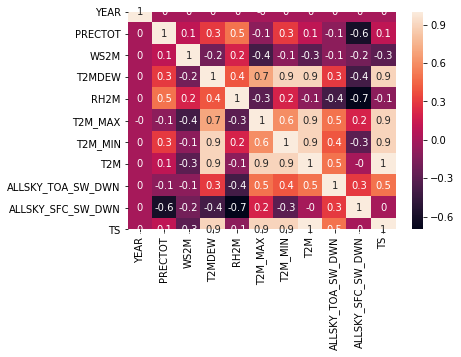

In [14]:
%matplotlib inline

matrice_corr = df_.corr().round(1)
sns.heatmap(data=matrice_corr, annot=True)

In [15]:
#['T2M', 'ALLSKY_SFC_SW_DWN', 'T2MDEW', 'T2M_MIN', 'YEAR', 'RH2M', 'surface (ha)']

In [16]:
df_sojaSM = pd.read_csv("../CSV/soja_Santa_Maria_1974_2018.txt", sep="\t")
df_sojaSM.head()

,Annee,surface (ha),Production (t),Productivite (kg/ha),Productivite (sacs/ha)
0,1974,12000,18000,1500,25.0
1,1975,9000,13500,1500,25.0
2,1976,9000,13500,1500,25.0
3,1977,13361,20042,1500,25.0
4,1978,23000,27600,1200,20.0


In [17]:
selection = df_sojaSM.Annee<1984
index2Remove = df_sojaSM[selection].index
df_sojaSM=df_sojaSM.drop(index2Remove)

In [18]:
X_VAL = df_[df_.YEAR==2019]

In [19]:
X_VAL.to_csv("2019Soja_SM.csv", index=False)

In [20]:
selection = df_.YEAR>2018
index2Remove = df_[selection].index
df_=df_.drop(index2Remove)

In [21]:
cmp = df_sojaSM.index[0]
for r in df_.index:
    if df_.YEAR[r] != df_sojaSM.Annee[cmp]:
        cmp = cmp+1
        
    if df_.YEAR[r] == df_sojaSM.Annee[cmp]:
        df_.at[r, 'Productivite (kg/ha)'] = df_sojaSM.at[cmp, 'Productivite (kg/ha)']
        df_.at[r, 'Production (t)'] = df_sojaSM.at[cmp, 'Production (t)']
        df_.at[r, 'surface (ha)'] = df_sojaSM.at[cmp, 'Production (t)']

In [22]:
df_.describe()

,YEAR,PRECTOT,WS2M,T2MDEW,RH2M,T2M_MAX,T2M_MIN,T2M,ALLSKY_TOA_SW_DWN,ALLSKY_SFC_SW_DWN,TS,Productivite (kg/ha),Production (t),surface (ha)
count,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000
mean,2001.089908,4.991152,1.222609,15.901875,77.791626,26.330925,13.976727,20.058936,40.078593,21.151702,20.135890,2110.473028,46914.862752,46914.862752
std,10.095596,10.839961,0.410521,3.595743,8.516595,3.756444,3.630771,3.357111,2.991107,8.817040,3.335697,659.284715,45284.236506,45284.236506
min,1984.000000,0.000000,0.420000,2.660000,42.810000,14.960000,1.250000,8.200000,33.060000,0.790000,8.660000,840.000000,7395.000000,7395.000000
25%,1992.000000,0.000000,0.920000,13.540000,72.340000,23.770000,11.440000,17.710000,37.660000,14.830000,17.790000,1620.000000,12870.000000,12870.000000
50%,2001.000000,0.290000,1.160000,16.050000,77.730000,26.380000,14.130000,20.210000,40.720000,23.650000,20.300000,2280.000000,29160.000000,29160.000000
75%,2010.000000,4.270000,1.460000,18.590000,84.030000,28.930000,16.570000,22.530000,42.800000,28.220000,22.540000,2646.000000,67600.000000,67600.000000
max,2018.000000,133.760000,2.870000,24.870000,97.000000,38.510000,23.750000,29.620000,44.940000,34.520000,29.180000,3361.000000,157974.000000,157974.000000


# Coefficient de Pearson

Le coefficient de Pearson ou Pearson r est une mesure qui exprime à quel point deux variables sont linéairement corrélées. Il est égale au quotient de la covariance des deux variables et du produit des deux écarts-types

In [23]:
from scipy.stats import pearsonr
for c in df_.columns:
    coeff_pearson,_ = pearsonr(df_[c],df_['Productivite (kg/ha)'])
    print(c, "coefficient de Pearson = {}".format(coeff_pearson))

YEAR coefficient de Pearson = 0.7535016563962424
PRECTOT coefficient de Pearson = 0.052679617071352804
WS2M coefficient de Pearson = 0.028088414504846455
T2MDEW coefficient de Pearson = 0.03397595331998547
RH2M coefficient de Pearson = 0.13830999003608166
T2M_MAX coefficient de Pearson = -0.07370306101621327
T2M_MIN coefficient de Pearson = -0.006807810215777146
T2M coefficient de Pearson = -0.0416934089949409
ALLSKY_TOA_SW_DWN coefficient de Pearson = -0.005930488953476965
ALLSKY_SFC_SW_DWN coefficient de Pearson = -0.005321528174882574
TS coefficient de Pearson = -0.04409404358089233
Productivite (kg/ha) coefficient de Pearson = 0.9999999999999993
Production (t) coefficient de Pearson = 0.7463052672840365
surface (ha) coefficient de Pearson = 0.7463052672840365


Nous pouvons observer une forte corrélation 

In [24]:
coeff_pearson,_ = pearsonr(df_sojaSM.Annee,df_sojaSM['Productivite (kg/ha)'])
print("coefficient de Pearson = {}".format(coeff_pearson))

coefficient de Pearson = 0.7522185387672521


In [25]:
 #PAS GÉNÉRIQUE !   
cmp = df_sojaSM.index[0]
firstYear = True
for r in df_.index:
    if firstYear :
        df_.at[r, 'Coeff_prod'] = 0 ##Année ref

    if df_.YEAR[r] != df_sojaSM.Annee[cmp]:
        cmp = cmp+1
        firstYear = False
    
    if df_.YEAR[r] == df_sojaSM.Annee[cmp] and firstYear == False:
        coef_prod = (df_sojaSM.at[cmp, 'Productivite (kg/ha)']/df_sojaSM.at[cmp-1, 'Productivite (kg/ha)'])
        df_.at[r, 'Coeff_prod'] = coef_prod


df_.describe()

,YEAR,PRECTOT,WS2M,T2MDEW,RH2M,T2M_MAX,T2M_MIN,T2M,ALLSKY_TOA_SW_DWN,ALLSKY_SFC_SW_DWN,TS,Productivite (kg/ha),Production (t),surface (ha),Coeff_prod
count,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000
mean,2001.089908,4.991152,1.222609,15.901875,77.791626,26.330925,13.976727,20.058936,40.078593,21.151702,20.135890,2110.473028,46914.862752,46914.862752,1.066005
std,10.095596,10.839961,0.410521,3.595743,8.516595,3.756444,3.630771,3.357111,2.991107,8.817040,3.335697,659.284715,45284.236506,45284.236506,0.466906
min,1984.000000,0.000000,0.420000,2.660000,42.810000,14.960000,1.250000,8.200000,33.060000,0.790000,8.660000,840.000000,7395.000000,7395.000000,0.000000
25%,1992.000000,0.000000,0.920000,13.540000,72.340000,23.770000,11.440000,17.710000,37.660000,14.830000,17.790000,1620.000000,12870.000000,12870.000000,0.807692
50%,2001.000000,0.290000,1.160000,16.050000,77.730000,26.380000,14.130000,20.210000,40.720000,23.650000,20.300000,2280.000000,29160.000000,29160.000000,1.000666
75%,2010.000000,4.270000,1.460000,18.590000,84.030000,28.930000,16.570000,22.530000,42.800000,28.220000,22.540000,2646.000000,67600.000000,67600.000000,1.200000
max,2018.000000,133.760000,2.870000,24.870000,97.000000,38.510000,23.750000,29.620000,44.940000,34.520000,29.180000,3361.000000,157974.000000,157974.000000,2.828571


In [26]:
coeff_pearson,_ = pearsonr(df_.Coeff_prod,df_['Productivite (kg/ha)'])
print("coefficient de Pearson = {}".format(coeff_pearson))
#Les points tombent près de la ligne, ce qui indique une relation négative forte entre les variables. La relation est négative car lorsqu'une variable chute, l'autre variable chute aussi.

coefficient de Pearson = 0.3603079595783668


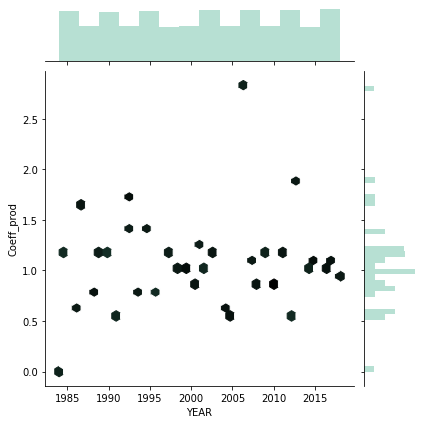

In [27]:
x = df_.YEAR
y = df_['Coeff_prod']

sns.jointplot(x=x, y=y, kind="hex", color="#4CB391")

Nous pouvons observer très clairement cette courbe que nous souhaitons désormais applatir 

In [28]:
columnsNamesArr = ['YEAR']
df_features = df_[columnsNamesArr]
# définir la variable cible
df_labels = df_[['Coeff_prod']]

scale = StandardScaler()
#X_scaled = pd.DataFrame(scale.fit_transform(df_features))
#Y_scaled = pd.DataFrame(scale.fit_transform(df_[['Coeff_prod']]))
X_scaled = df_features
Y_scaled = df_[['Coeff_prod']]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_scaled, test_size=0.25, random_state=1)
3
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(max_depth=None, n_estimators=100)
clf.fit(X_train, y_train.values.ravel())

RandomForestRegressor()

In [29]:
moylast5Y = 0
cmp = 0
for r in df_.index:
    if df_.YEAR[r] > (df_.YEAR.max() - 10):
        cmp=cmp+1
        moylast5Y = moylast5Y + df_.Coeff_prod[r]

In [30]:
moylast5Y = moylast5Y / cmp
moylast5Y

1.0776578869001598

In [31]:
estimated_2019 = clf.predict([[2019]])
coeff_prod_2019 = estimated_2019 * moylast5Y

In [32]:
coeff_prod_2019

array([1.02603548])

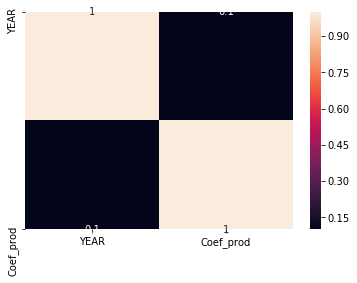

In [33]:
year_inflation = pd.DataFrame(df_.YEAR)
year_inflation["Coef_prod"]=df_.Coeff_prod
#year_inflation["Productivite (kg/ha)"]=df_["Productivite (kg/ha)"]
matrice_corr = year_inflation.corr().round(1)
sns.heatmap(data=matrice_corr, annot=True)

# Année ref

In [34]:
class AnneeRef:        
    def __init__(self, Annee, Dataframe):
        self.Annee = Annee
        self.df_ = pd.DataFrame()
        self.df_ = self.df_.append(Dataframe[Dataframe.YEAR==(Annee-1)], ignore_index=True)
        self.df_.loc[self.df_.YEAR==(Annee-1), "YEAR"]=Annee
        self.DOY = 0
    
    def put_back_year(self):
        self.df_.YEAR=self.Annee
        
    def addRow(self, row):
        for columns in row:
            self.df_.loc[self.DOY, columns] = row[columns].values
        self.DOY = self.DOY + 1
        
    def slight_mean(self, Annee, Dataframe):
        size_df = len(self.df_)
        size_param = len(Dataframe[Dataframe.YEAR==Annee])
        if(size_df<size_param):
            for i in range(0, size_df):
                df1 = pd.DataFrame()
                df1 = df1.append(Dataframe[Dataframe.YEAR==Annee], ignore_index=True)
                self.df_.loc[i]=self.df_.loc[i].add(df1.loc[i], fill_value=0)
                self.df_.loc[i] = self.df_.loc[i].div(2)
        else:
            for i in range(0, size_param):
                df1 = pd.DataFrame()
                df1 = df1.append(Dataframe[Dataframe.YEAR==Annee], ignore_index=True)
                self.df_.loc[i]=self.df_.loc[i].add(df1.loc[i], fill_value=0)
                self.df_.loc[i] = self.df_.loc[i].div(2)
    
        self.put_back_year()
            
    
    def historical_average(self, Dataframe):
        startPoint = df_.YEAR[df_.YEAR.index[0]]
        endPoint = df_.YEAR[df_.YEAR.idxmax()]
        selection = df_.YEAR==startPoint
        for i in range(startPoint, endPoint):
            Year = int(df_[selection].iloc[0].YEAR)
            self.slight_mean(Year, self.df_)

In [35]:
annee_moy = AnneeRef(2019, df_)
annee_moy.historical_average(df_)

In [36]:
annee_moy.df_

,YEAR,PRECTOT,WS2M,T2MDEW,RH2M,T2M_MAX,T2M_MIN,T2M,ALLSKY_TOA_SW_DWN,ALLSKY_SFC_SW_DWN,TS,Productivite (kg/ha),Production (t),surface (ha),Coeff_prod
0,2019,10.30,1.25,20.95,83.77,28.75,19.80,23.84,33.99,9.37,23.70,3200.0,157904.0,157904.0,0.952098
1,2019,31.62,1.85,19.36,91.17,27.04,13.22,20.87,34.19,10.94,20.68,3200.0,157904.0,157904.0,0.952098
2,2019,1.83,1.46,11.58,85.37,18.08,10.23,14.00,34.39,5.40,14.32,3200.0,157904.0,157904.0,0.952098
3,2019,6.05,1.24,12.26,82.72,21.72,10.01,15.16,34.59,13.25,15.52,3200.0,157904.0,157904.0,0.952098
4,2019,0.03,0.95,10.85,74.39,21.89,9.12,15.32,34.79,24.51,15.42,3200.0,157904.0,157904.0,0.952098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2019,4.34,0.91,21.71,83.25,28.20,21.73,24.71,43.61,15.95,24.49,3200.0,157904.0,157904.0,0.952098
74,2019,1.36,1.38,21.58,77.53,31.62,19.54,25.72,43.65,29.30,25.83,3200.0,157904.0,157904.0,0.952098
75,2019,0.70,1.31,22.66,82.40,29.83,21.72,25.84,43.68,12.32,25.67,3200.0,157904.0,157904.0,0.952098
76,2019,8.73,0.90,20.90,90.29,24.54,20.35,22.58,43.70,8.56,22.62,3200.0,157904.0,157904.0,0.952098


In [37]:
annee_ = AnneeRef(2019, df_)
#row_1 = pd.DataFrame(df_[df_.YEAR==2001].head(1))
#annee_.addRow(row_1)
#annee_.slight_mean(2018, df_)
#annee_.slight_mean(2017, df_)
#annee_.slight_mean(2016, df_)
annee_.historical_average(df_)
annee_.df_

,YEAR,PRECTOT,WS2M,T2MDEW,RH2M,T2M_MAX,T2M_MIN,T2M,ALLSKY_TOA_SW_DWN,ALLSKY_SFC_SW_DWN,TS,Productivite (kg/ha),Production (t),surface (ha),Coeff_prod
0,2019,10.30,1.25,20.95,83.77,28.75,19.80,23.84,33.99,9.37,23.70,3200.0,157904.0,157904.0,0.952098
1,2019,31.62,1.85,19.36,91.17,27.04,13.22,20.87,34.19,10.94,20.68,3200.0,157904.0,157904.0,0.952098
2,2019,1.83,1.46,11.58,85.37,18.08,10.23,14.00,34.39,5.40,14.32,3200.0,157904.0,157904.0,0.952098
3,2019,6.05,1.24,12.26,82.72,21.72,10.01,15.16,34.59,13.25,15.52,3200.0,157904.0,157904.0,0.952098
4,2019,0.03,0.95,10.85,74.39,21.89,9.12,15.32,34.79,24.51,15.42,3200.0,157904.0,157904.0,0.952098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2019,4.34,0.91,21.71,83.25,28.20,21.73,24.71,43.61,15.95,24.49,3200.0,157904.0,157904.0,0.952098
74,2019,1.36,1.38,21.58,77.53,31.62,19.54,25.72,43.65,29.30,25.83,3200.0,157904.0,157904.0,0.952098
75,2019,0.70,1.31,22.66,82.40,29.83,21.72,25.84,43.68,12.32,25.67,3200.0,157904.0,157904.0,0.952098
76,2019,8.73,0.90,20.90,90.29,24.54,20.35,22.58,43.70,8.56,22.62,3200.0,157904.0,157904.0,0.952098


In [38]:
# Nous pourrions alors faire un update sur les données journalière et ajouter les lignes au fur et à mesure que le dataset évolue

# REGRESSION

In [39]:
columnsNamesArr = ['PRECTOT', 'T2M', 'ALLSKY_SFC_SW_DWN', 'T2MDEW', 'T2M_MIN', 'RH2M', 'YEAR', 'Coeff_prod']
df_features = df_[columnsNamesArr]
# définir la variable cible
df_labels = df_[['Productivite (kg/ha)']]

# SCALE DATA

Le Feature Scaling est une étape nécessaire voire indispensable de remise à niveau de caractéristiques de notre modèle de Machine Learning. Pourquoi ? et bien tout simplement car derrière chaque algorithme se cache des formules mathématiques. Et ces formules mathématiques n’apprécient guère les variations d’échelle de valeurs entre chaque caractéristiques.

In [40]:
from sklearn.preprocessing import QuantileTransformer
#scale = StandardScaler().fit(df_features)
scale = QuantileTransformer(n_quantiles=75)
X_scaled = pd.DataFrame(scale.fit_transform(df_features))
#X_scaled = df_features
#Y_scaled = pd.DataFrame(scale.fit_transform(df_[['Productivite (kg/ha)']]))
Y_scaled = df_labels

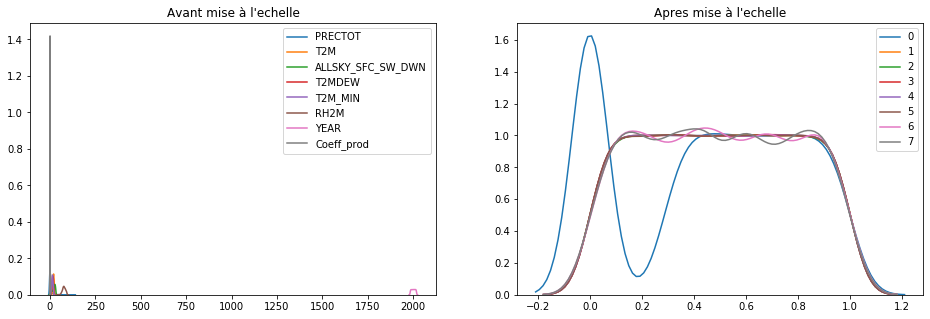

In [41]:
def plotGraph(pdf, pscaled_df):
    fig, (a, b) = plt.subplots(ncols=2, figsize=(16, 5))
    a.set_title("Avant mise à l'echelle")
    for col in pdf.columns:
        sns.kdeplot(pdf[col], ax=a)
    b.set_title("Apres mise à l'echelle")
    for col in pscaled_df.columns:
        sns.kdeplot(pscaled_df[col], ax=b)
    plt.show()

plotGraph(df_features, X_scaled)
#plotGraph(df_[['Productivite (kg/ha)']], Y_scaled)

# TRAIN

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2180, 8)
(545, 8)
(2180, 1)
(545, 1)


In [43]:
rf = RandomForestRegressor(max_depth=14, n_estimators=157, random_state=1)
rf.fit(X_train, y_train.values.ravel())

train_score = rf.score(X_train, y_train)
print('train score = ',train_score )

ypred = rf.predict(X_test)
mse = mean_squared_error(ypred  , y_test)
rmse_rf_test = np.sqrt(mean_squared_error(ypred,y_test))
print(' Random Forest RMSE = ',rmse_rf_test )

r2_rf = r2_score(y_test, ypred)
print(' Random Forest R2 = ',r2_rf)

ypred = rf.predict(X_train)
mse = mean_squared_error(ypred  , y_train)
rmse_rf_train = np.sqrt(mean_squared_error(ypred,y_train))
print(' Random Forest TRAIN RMSE = ',rmse_rf_train )

#faire un affichage du déroulement

train score =  1.0
 Random Forest RMSE =  0.0
 Random Forest R2 =  1.0
 Random Forest TRAIN RMSE =  0.0


In [44]:
print('Random Forest Cross-validation scores')
sc_rfc = cross_val_score(rf, X_test, y_test.values.ravel(), cv=5)
print("AUC: %0.2f (+/- %0.2f)" % (sc_rfc.mean(), sc_rfc.std() * 2))

Random Forest Cross-validation scores
AUC: 1.00 (+/- 0.00)


In [45]:
#Kfold validation
from sklearn.model_selection import KFold
"""
param_grid = { 
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'max_depth' : [6,8,10,12,14, 16],
    'random_state': [1, 2]
    
            
}
gs = GridSearchCV(RandomForestRegressor(), param_grid, cv = 10)
gs_res = gs.fit(X_train, y_train.values.ravel())
print('Best params random forest : ')
print(gs_res.best_params_)
"""
kf = KFold(n_splits=10)
onetime=1
for train_index, test_index in kf.split(X_scaled):
    #print("TRAIN:", train_index, "TEST:", test_index)
    print("----------------------------------------------")
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = Y_scaled.iloc[train_index], Y_scaled.iloc[test_index]
    
    rf = RandomForestRegressor(max_depth=10, n_estimators=200, random_state=1)#8 400 1
    rf.fit(X_train, y_train.values.ravel())

    train_score = rf.score(X_train, y_train)
    print('train score = ',train_score )

    ypred = rf.predict(X_test)
    mse = mean_squared_error(ypred  , y_test)
    rmse_rf_test = np.sqrt(mean_squared_error(ypred,y_test))
    print(' Random Forest RMSE = ',rmse_rf_test )

    r2_rf = r2_score(y_test, ypred)
    print(' Random Forest R2 = ',r2_rf)

----------------------------------------------
train score =  1.0
 Random Forest RMSE =  300.7437871253627
 Random Forest R2 =  -0.23983194001319608
----------------------------------------------
train score =  1.0
 Random Forest RMSE =  187.64511434548177
 Random Forest R2 =  0.13128573562911794
----------------------------------------------
train score =  1.0
 Random Forest RMSE =  139.61530033600215
 Random Forest R2 =  0.9029667380614343
----------------------------------------------
train score =  1.0
 Random Forest RMSE =  173.8741745658404
 Random Forest R2 =  0.4723986107850926
----------------------------------------------
train score =  1.0
 Random Forest RMSE =  139.35821768604114
 Random Forest R2 =  0.20659633448380244
----------------------------------------------
train score =  1.0
 Random Forest RMSE =  476.3602406707677
 Random Forest R2 =  0.17642329128631118
----------------------------------------------
train score =  1.0
 Random Forest RMSE =  109.64738670741184
 R

In [46]:
X_scaled = df_features
Y_scaled = df_labels

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2180, 8)
(545, 8)
(2180, 1)
(545, 1)


In [48]:
rf = RandomForestRegressor(max_depth=8, n_estimators=400, random_state=1)
rf.fit(X_train, y_train.values.ravel())

train_score = rf.score(X_train, y_train)
print('train score = ',train_score )

ypred = rf.predict(X_test)
mse = mean_squared_error(ypred  , y_test)
rmse_rf_test = np.sqrt(mean_squared_error(ypred,y_test))
print(' Random Forest RMSE = ',rmse_rf_test )

r2_rf = r2_score(y_test, ypred)
print(' Random Forest R2 = ',r2_rf)

ypred = rf.predict(X_train)
mse = mean_squared_error(ypred  , y_train)
rmse_rf_train = np.sqrt(mean_squared_error(ypred,y_train))
print(' Random Forest TRAIN RMSE = ',rmse_rf_train )

train score =  0.9999992503492845
 Random Forest RMSE =  0.5516935283496598
 Random Forest R2 =  0.9999993181163852
 Random Forest TRAIN RMSE =  0.5685320390891047


In [49]:
append = open("results.txt","w")

In [50]:
cmp = X_VAL.index[0]
size = len(X_VAL)
for i in range(cmp, cmp+size):
    X_VAL.at[i, "Coeff_prod"]=coeff_prod_2019
    
X_VAL_Features = X_VAL[columnsNamesArr]

ypred = rf.predict(X_VAL_Features)
print(ypred[0])
print('Erreur:~', 3300 - ypred[0])

str1 = "Santa-Maria production [coeff production 2019]: {} - Erreur:~ {} \n".format(ypred[0], 3300 - ypred[0])
append.write(str1)
cmp = X_VAL.index[0]
size = len(X_VAL)
for i in range(cmp, cmp+size):
    X_VAL.at[i, "Coeff_prod"]=moylast5Y

X_VAL_Features = X_VAL[columnsNamesArr]

ypred = rf.predict(X_VAL_Features)
print(ypred[0])
print('Erreur:~', 3300 - ypred[0])
str1 = "Santa-Maria production [moyenne des dernières années]: {} - Erreur:~ {} \n".format(ypred[0], 3300 - ypred[0])
append.write(str1)

3200.0
Erreur:~ 100.0
3280.9025
Erreur:~ 19.097499999999854


96

# Test avec Année REFERENCE

In [51]:
df_moy = annee_.df_
cmp = df_moy.index[0]
size = len(df_moy)
for i in range(cmp, cmp+size):
    df_moy.at[i, "Coeff_prod"]=3300/3200
    
X_VAL_Features = df_moy[columnsNamesArr]

ypred = rf.predict(X_VAL_Features)
print(ypred[0])
print('Erreur:~', 3300 - ypred[0])

append = open("results.txt","a")
str1 = "\nSantaMaria production [vrai coeff production + Moyenne historique]: {} - Erreur:~ {} \n".format(ypred[0], 3300 - ypred[0])
append.write(str1)
append.close()

3200.0
Erreur:~ 100.0


In [52]:
# 3300 !! 2019 https://cidades.ibge.gov.br/brasil/rs/santa-maria/pesquisa/14/0?ano=2019